## Library import

### If you are using the github notebook use this line to unzip the samples archieve

In [4]:
#!unzip samples.zip

In [ ]:
pip install fastwer

In [33]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import os
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.nn import functional
import numpy as np
import pandas as pd
from torchmetrics import CharErrorRate
from torchmetrics.functional import char_error_rate

Defining some hyperparameters

In [7]:
data_path  = "/kaggle/input/captcha-version-2-images/samples"
split_frac = 0.20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
img_shape = ()

## Dataset class
 - loading data from the directory
 - Calculating the image shape and symbols occuring in the dataset

In [8]:

class ImageData(Dataset):
    def load_image(self, path):
        img = Image.open(path).convert('RGB')
        trans = transforms.ToPILImage()
        trans1 = transforms.ToTensor()
        res = trans1(img)
        return  res

    def get_label(self, filename):
            label = filename.split('.')[0]
            self.symbols.update(set(list(label)))
            return label 

    def __init__(self, data_path):
        self.samples = []
        self.symbols = set()
        self.img_shape = None
        super(self.__class__, self).__init__()
        for filename in os.listdir(data_path):
            if filename != 'samples':
                file_path = data_path + "/" + filename
                print(f"processing {file_path}")
                image = self.load_image(file_path)
                self.img_shape = tuple(image.shape)
                image_label = self.get_label(filename)
                self.samples.append((image, image_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [9]:
dataset = ImageData(data_path)
img_shape = dataset.img_shape
classes = list(dataset.symbols)


processing /kaggle/input/captcha-version-2-images/samples/6n6gg.png
processing /kaggle/input/captcha-version-2-images/samples/fncnb.png
processing /kaggle/input/captcha-version-2-images/samples/nxf2c.jpg
processing /kaggle/input/captcha-version-2-images/samples/nbwnn.png
processing /kaggle/input/captcha-version-2-images/samples/ebcbx.png
processing /kaggle/input/captcha-version-2-images/samples/nxn4f.png
processing /kaggle/input/captcha-version-2-images/samples/2en7g.png
processing /kaggle/input/captcha-version-2-images/samples/y866y.png
processing /kaggle/input/captcha-version-2-images/samples/xcmbp.png
processing /kaggle/input/captcha-version-2-images/samples/g247w.png
processing /kaggle/input/captcha-version-2-images/samples/56ncx.png
processing /kaggle/input/captcha-version-2-images/samples/n8wxm.jpg
processing /kaggle/input/captcha-version-2-images/samples/6ng6n.png
processing /kaggle/input/captcha-version-2-images/samples/x362g.png
processing /kaggle/input/captcha-version-2-image

In [10]:
# adding - this is important and it should be first !!! or the length would be fitted with trash
classes= ['-'] + classes
classes_num = len(classes)
classes

['-',
 'c',
 'b',
 '4',
 'e',
 'd',
 'y',
 '6',
 'p',
 'm',
 'w',
 '2',
 'f',
 'g',
 '3',
 'x',
 '5',
 '7',
 'n',
 '8']

In [11]:
idx2char = {k:v for k,v in enumerate(classes, start=0)}
char2idx = {v:k for k,v in idx2char.items()}
print(idx2char)
print(char2idx)

{0: '-', 1: 'c', 2: 'b', 3: '4', 4: 'e', 5: 'd', 6: 'y', 7: '6', 8: 'p', 9: 'm', 10: 'w', 11: '2', 12: 'f', 13: 'g', 14: '3', 15: 'x', 16: '5', 17: '7', 18: 'n', 19: '8'}
{'-': 0, 'c': 1, 'b': 2, '4': 3, 'e': 4, 'd': 5, 'y': 6, '6': 7, 'p': 8, 'm': 9, 'w': 10, '2': 11, 'f': 12, 'g': 13, '3': 14, 'x': 15, '5': 16, '7': 17, 'n': 18, '8': 19}


Some statistics

In [12]:
print(f"total number of samples = {len(dataset)}")
print(f"shape of each image is {img_shape}")
print(f"symbols to recognize are {classes}, \nwhich is in total {len(classes)} elements")

total number of samples = 1070
shape of each image is (3, 50, 200)
symbols to recognize are ['-', 'c', 'b', '4', 'e', 'd', 'y', '6', 'p', 'm', 'w', '2', 'f', 'g', '3', 'x', '5', '7', 'n', '8'], 
which is in total 20 elements


## Train test split
Here we split the dataset in train and test in the fraction defined before

In [13]:
# that line used to work with fracs locally but on kaggle it stopped so i added ints manually which is not nice but whatever
trainset, valset = random_split(dataset, [856, 214])
train_loader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=16, shuffle=True, num_workers=2)

In [14]:
print(f"length of trainset is {len(trainset)}, length of validation set is {len(valset)}")
print(f"length of training set is {len(train_loader)}, length of validation loader {len(val_loader)}")

length of trainset is 856, length of validation set is 214
length of training set is 54, length of validation loader 14


In [15]:
print(trainset[0])

(tensor([[[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0

This nasty line of code below crashed my whole jupiter kernel I have no idea why :( It just made an infinity loop even though in collab it worked fine 

In [16]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('cfn53', '2g783', 'x38fn', '7xcyd', '244e2', '67dey', 'fg7mg', '662bw', 'pcmcc', '6ge3p', '47e4p', '2npg6', 'dgcm4', 'xf5g7', 'e3cfe', '52447')


## Model class

Being honest I didn't create a bicycle, I tried at first but the quality really sucked so i just read the article the picture is taken from and a few articles from other cool guys and taken the structure from them, worked not bad even though the optimizator matters that's the fact

In [17]:
class MyNeuralNetwork(nn.Module):

    def __init__(self, vocab_size, dropout=0.5):
        super(MyNeuralNetwork, self).__init__()

        self.dropout = nn.Dropout(dropout)
        # convilutional part
        self.convlayer = nn.Sequential(
            nn.Conv2d(3, 32, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(32, 64, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(64, 128, (3,3), stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 256, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((1,2), 2),

            nn.Conv2d(256, 512, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((1,2), 2),

            nn.Conv2d(512, 512, (2,2), stride=1, padding=0),
            self.dropout
        )

        self.mapSeq = nn.Sequential(
            nn.Linear(1024, 256),
            self.dropout
        )
        #Bi Lstm (gru)
        
        self.lstm_0 = nn.GRU(256, 256, bidirectional=True)  
        self.lstm_1 = nn.GRU(512, 256, bidirectional=True)

        self.out = nn.Sequential(
            nn.Linear(512, vocab_size),
        )
        
        
    def forward(self, x): 
        x = self.convlayer(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)
     
        x = self.mapSeq(x)

        x, _ = self.lstm_0(x)
        x, _ = self.lstm_1(x)

        x = self.out(x)   
        return x.permute(1, 0, 2)

## Loss function

Used CTCloss function just like in the article.
At first I tried to form a class for the loss with the method compute loss but got a value error during the forward operation and couldn't really figure out how to fix it except making it all into a big class, but i didn't find it fancy so i left it like that.

In [18]:
criterion = nn.CTCLoss(blank=0)
def encode_text_batch(text):
    
    text_lens = torch.IntTensor([len(t) for t in text])
    
    text = "".join(text)
    text = torch.IntTensor([char2idx[c] for c in text])
    return text, text_lens

def compute_loss(y, pred):
    pred = functional.log_softmax(pred, 2)   
    pred_lens = torch.full(size=(pred.size(1),), fill_value=pred.size(0), dtype=torch.int32).to(device) 
    y,y_lens = encode_text_batch(y)
    loss = criterion(pred, y, pred_lens, y_lens)

    return loss

At first I have been using models with a very small learning rate and they had been stucking at some points so I have chosen the bigger one. Also used a nesterov momentum and learning rate decay as an optimization for learning. Tried to use ADAM before but it did work awfully more probably cause i couldn't figure out the good parameters for that but sgd with optimizations works fine.

In [19]:
model = MyNeuralNetwork(classes_num).to(device)
opt = torch.optim.SGD(
    model.parameters(), lr=0.02, nesterov=True,
    weight_decay=1e-5, momentum=0.7
)

The saint three: nn model, optimizator and loss functions are working fine together making a harmonious solution.Just some good old bad ass training, as u could see not many epoches nedeed to train it.

In [20]:
def train_model(model, train_loader, val_loader, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    
    for epoch in range(n_epochs):
        print(f"processing {epoch} epoch")
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        model.train(True) 
        for X_batch, y_batch in train_loader:
            X_batch.to(device)

            predictions = model.forward(X_batch)
            loss = compute_loss(y_batch, predictions) # in this sequence this is important
            loss.backward()
            opt.step()
            opt.zero_grad()


            ep_train_loss.append(loss.item())

        model.eval() 
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch.to(device)
                predictions = model(X_batch)
                loss = compute_loss(y_batch, predictions)
                ep_val_loss.append(loss)
        # print the results for this epoch:

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")

    return train_loss , val_loss

In [21]:
train_loss, val_loss = train_model(model, train_loader, val_loader, opt, n_epochs=20 )

processing 0 epoch
	  training loss: 3.322996
	validation loss: 3.604061
processing 1 epoch
	  training loss: 3.257114
	validation loss: 3.323144
processing 2 epoch
	  training loss: 3.239098
	validation loss: 3.334743
processing 3 epoch
	  training loss: 3.204637
	validation loss: 3.137129
processing 4 epoch
	  training loss: 2.980662
	validation loss: 2.899746
processing 5 epoch
	  training loss: 2.654791
	validation loss: 2.869708
processing 6 epoch
	  training loss: 2.288884
	validation loss: 2.650206
processing 7 epoch
	  training loss: 1.919905
	validation loss: 1.726364
processing 8 epoch
	  training loss: 1.459795
	validation loss: 1.530826
processing 9 epoch
	  training loss: 1.067609
	validation loss: 0.752286
processing 10 epoch
	  training loss: 0.699048
	validation loss: 0.749804
processing 11 epoch
	  training loss: 0.491401
	validation loss: 0.635672
processing 12 epoch
	  training loss: 0.378489
	validation loss: 0.512056
processing 13 epoch
	  training loss: 0.304655
	

Plotting the losses, looking for overfitting

In [22]:
def plot_train_process(train_loss, val_loss):

    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='validation')
    plt.legend()

Hmm...Not that bad, could put even smaller number of epoches

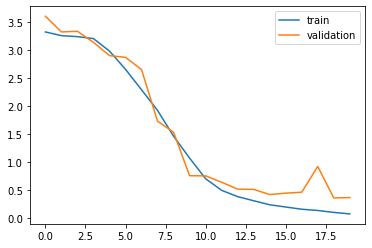

In [23]:
plot_train_process(train_loss, val_loss)

## Results

Now let's calculate metrics. I used CER cause i trust teachers who recommended it and I appreciate levenshtein distance for string difference

In [24]:
def decode_predictions(pred):
    pred = functional.softmax(pred, 2).argmax(2) 
    pred = pred.numpy().T 

    text_batch_tokens_new = []
    for text_tokens in pred:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [37]:
results_train = pd.DataFrame(columns=['actual', 'prediction', 'distance'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
cer_metric = []
with torch.no_grad():
    for image_batch, text_batch in train_loader:
        #make prediction
        pred = model(image_batch.to(device)) 
        text_batch_pred = [t.replace("-", "") for t in decode_predictions(pred.cpu())]
         #print(text_batch, text_batch_pred)
        # calc metric 
        batch_dist = []
        for i in range(len(text_batch)):
            dist = char_error_rate(text_batch[i], text_batch_pred[i]).numpy()
            batch_dist.append(dist)
        cer_metric.append(batch_dist)
        #make a dataset of what was recognized and what actually should be 
        df = pd.DataFrame(columns=['actual', 'prediction', 'distance'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        df['distance'] = batch_dist
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

This is a dataframe which has an actual captcha, the one which was predicted and theirs distance, as u can see the results are pretty good.

In [38]:
results_train

,actual,prediction,distance
0,yd38e,yd38e,0.0
1,bgxcd,bgxcd,0.0
2,befbd,befbd,0.0
3,53wp3,53wp3,0.0
4,8bbm4,8bbm4,0.0
...,...,...,...
851,8db67,8db67,0.0
852,f4wfn,f4wfn,0.0
853,g3ex3,g3ex3,0.0
854,x8xnp,x8xnp,0.0


In [42]:
result_metric = char_error_rate(list(results_train['actual']),results_train['prediction'])
print(f"result CER for our OCR model is {result_metric}")

result CER for our OCR model is 0.05378486216068268


Just slighly more than 5% of wrong character regonition, great result!!!

Let's take a look at the worst recognized ones

In [43]:
results_train.sort_values(by='distance', ascending=False)

,actual,prediction,distance
708,77n6g,77ndgg,0.33333334
391,dgcm4,dgcmm44,0.2857143
666,bny4w,bny44ww,0.2857143
285,my84e,myy844e,0.2857143
553,p4nm4,p4nmm44,0.2857143
...,...,...,...
332,c5xne,c5xne,0.0
333,xnn4d,xnn4d,0.0
334,n5w5g,n5w5g,0.0
339,n373n,n373n,0.0


Most of the "bad" cases for your nn is double letters one after another.Maybe data augmentation would help?.

<img src="fascinating-star-trek.gif.gif" width="750" align="center">
I find this task very fascinating, even though I an still not very familiar with easy creating perfect layers structure. During this lab as u could see I have bumped into some moments I didn't get right. Waiting for the critics and advises for my work!